# The DataFrame

The RAPIDS ecosystem is built on the concept of a `cudf.DataFrame`, built on [Apache Arrow](http://arrow.apache.org/), shared between all of the different libraries and packages.

There are two libraries specific to data manipulation:
- BlazingSQL: SQL commands on a `cudf.DataFrame`
- cuDF: pandas-like commands on a `cudf.DataFrame`

## BlazingSQL (BSQL)
[GitHub](https://github.com/BlazingDB/blazingsql)

As mentioned in the [Welcome Notebook](../welcome.ipynb), BlazingSQL is a SQL engine built on top of cuDF, the `cudf.DataFrame` package. This means you can easily chain together SQL queries in Python and the RAPIDS ecosystem to build complex and scalable data pipelines for machine learning, graph analytics, and more.

We'll show off a series of examples that demonstrate the power of BlazingSQL.

#### SQL Query a `cudf.DataFrame`
To start we always need to make a BlazingContext. The BlazingContext is a live session with the SQL engine, and stores information such as created tables, registered storage plugins, and more.

In [1]:
from blazingsql import BlazingContext
bc = BlazingContext()

BlazingContext ready


Then we can create a cuDF as if it were a pandas DataFrame, and make a BSQL table off of it using the `.create_table()` method. This is a zero-copy process, meaning it is very fast, and won't take up more space on your GPU.

In [2]:
import cudf, os

# read CSV file into cuDF DataFrame
df = cudf.read_csv('../data/sample_taxi.csv')

# create table from cuDF DataFrame
bc.create_table('taxi', df)

We can no run a SQL query on that `cudf.DataFrame` with the `.sql()` method which returns a new cuDF.

In [3]:
bc.sql('''
       select 
           cast(substring(tpep_pickup_datetime,0,10) || ' 00:00:00' as timestamp) as pickup_date, 
           count(*), 
           avg(trip_distance), 
           avg(fare_amount) 
       from taxi 
           group by 
               cast(substring(tpep_pickup_datetime,0,10) || ' 00:00:00' as timestamp)
           order by 
               cast(substring(tpep_pickup_datetime,0,10) || ' 00:00:00' as timestamp)
           limit 10
           ''')

,pickup_date,EXPR$1,EXPR$2,EXPR$3
0,2015-01-01,11844,2.191915,9.768704
1,2015-01-02,11735,1.929576,9.376985
2,2015-01-03,11716,1.911964,9.096707
3,2015-01-04,11706,2.009458,9.124330
4,2015-01-05,11758,1.823169,8.937642
5,2015-01-06,11785,1.783051,9.249030
6,2015-01-07,11737,1.790137,9.236119
7,2015-01-08,11634,1.801203,9.401402
8,2015-01-09,11791,1.876957,9.705466
9,2015-01-10,11615,1.920695,9.363473


#### SQL Query a CSV File
We could also save ourselves some time and run `.create_table()` directly on a [supported file format](https://docs.blazingdb.com/docs/text-files).

In [4]:
bc.create_table('taxi', '../data/sample_taxi.csv', header=0)

In [5]:
%%time
bc.sql('select count(*) from taxi')

CPU times: user 165 ms, sys: 116 ms, total: 281 ms
Wall time: 281 ms


,COUNT(*)
0,1000000


#### SQL Query a Data Lake (AWS S3)
You can register multiple [Storage Plugins](https://docs.blazingdb.com/docs/connecting-data-sources) on a BlazingContext. These Storage Plugins help BSQL optimize IO requests during query execution. For example, with [Apache Parquet](https://parquet.apache.org/) files on AWS S3, BSQL can register AWS S3 buckets with the `.s3('name', bucket_name='bucket_name')` method, and will read the metadata and skip files/partitions based on a SQL query. 

In [6]:
bc.s3('blazingsql-colab', bucket_name='blazingsql-colab')

(True,
 '',
 OrderedDict([('type', 's3'),
              ('bucket_name', 'blazingsql-colab'),
              ('access_key_id', ''),
              ('secret_key', ''),
              ('session_token', ''),
              ('encryption_type', <S3EncryptionType.NONE: 1>),
              ('kms_key_amazon_resource_name', ''),
              ('endpoint_override', '')]))

Now we can reference files in AWS S3 with a filesystem path convention `s3://storage_plugin_name/path_to_file...`.

In [7]:
bc.create_table('big_taxi', 's3://blazingsql-colab/yellow_taxi/1_0_0.parquet')

In [8]:
%%time
bc.sql('select count(*) from big_taxi')

CPU times: user 32.8 ms, sys: 21.7 ms, total: 54.5 ms
Wall time: 157 ms


,COUNT(*)
0,18826831


Those are the most common features leveraged in BSQL. What makes it such a powerful and extensible tool though is the fact that everything in-GPU-memory is a `cudf.DataFrame`.

Let's now learn about cuDF.

## cuDF
[GitHub](https://github.com/rapidsai/cudf)

As mentioned in the [Welcome Notebook](../welcome.ipynb), cuDF is a pandas-like DataFrame library. cuDF is almost a drop-in replacement for pandas, the main difference is that it is operating on GPU memory. We'll walk through some examples that demonstrate how to use cuDF.

Parts of this were borrowed and lightly adapted from [10 Minutes to cuDF and Dask-cudf](https://rapidsai.github.io/projects/cudf/en/0.12.0/10min.html).

Creating a `cudf.Series`

In [9]:
s = cudf.Series([1,2,3,None,4])
s

0       1
1       2
2       3
3    null
4       4
dtype: int64

Creating a `cudf.DataFrame` with 1000 rows.

In [10]:
n = 1000
df = cudf.DataFrame(
                    {'a':range(n),
                     'b':range(500, n + 500),
                     'c':range(1000, n + 1000)}
                   )
df

,a,b,c
0,0,500,1000
1,1,501,1001
2,2,502,1002
3,3,503,1003
4,4,504,1004
...,...,...,...
995,995,1495,1995
996,996,1496,1996
997,997,1497,1997
998,998,1498,1998


The `cudf.DataFrame` can be treated like a `pandas.DataFrame`.

Such as sorting by values in descending order.

In [11]:
df.sort_values(by='b', ascending=False)

,a,b,c
999,999,1499,1999
998,998,1498,1998
997,997,1497,1997
996,996,1496,1996
995,995,1495,1995
...,...,...,...
4,4,504,1004
3,3,503,1003
2,2,502,1002
1,1,501,1001


Selection by position.

In [12]:
df.iloc[0:3, 0:2]

,a,b
0,0,500
1,1,501
2,2,502


Or performing a `Join`.

In [13]:
df_a = cudf.DataFrame()
df_a['key'] = ['a', 'b', 'c', 'd', 'e']
df_a['vals_a'] = [float(i + 10) for i in range(5)]

df_b = cudf.DataFrame()
df_b['key'] = ['a', 'c', 'e']
df_b['vals_b'] = [float(i+100) for i in range(3)]

merged = df_a.merge(df_b, on=['key'], how='left')
merged

,key,vals_a,vals_b
0,a,10.0,100.0
1,c,12.0,101.0
2,e,14.0,102.0
3,b,11.0,null
4,d,13.0,null


You can also use BSQL and cuDF together to chain together a data pipeline.

In [14]:
df = bc.sql('select * from taxi where trip_distance < 10')

Let's use the `.describe()` method to better understand taxi rides under 10 miles.

In [15]:
df.describe()

,VendorID,passenger_count,trip_distance,pickup_x,pickup_y,RateCodeID,dropoff_x,dropoff_y,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount
count,987618.000000,987618.000000,987618.000000,9.876180e+05,9.876180e+05,987618.000000,9.876180e+05,9.876180e+05,987618.00000,987618.000000,987618.000000,987618.000000,987618.000000,987618.000000,987618.000000
mean,1.526553,1.679614,2.053153,-8.235422e+06,4.975973e+06,1.008475,-8.235223e+06,4.976014e+06,1.37624,10.100790,0.315590,0.499046,1.341565,0.068747,8.412901
std,0.499295,1.342171,1.647690,2.239713e+03,3.165829e+03,0.456450,2.420791e+03,3.461383e+03,0.49543,6.031533,0.366221,0.024691,1.755523,0.657235,8.775337
min,1.000000,0.000000,0.000000,-8.252582e+06,4.965257e+06,1.000000,-8.253923e+06,4.965256e+06,1.00000,-150.000000,-1.000000,-0.500000,-0.750000,-26.000000,-111.050000
25%,1.000000,1.000000,0.950000,-8.236787e+06,4.973858e+06,1.000000,-8.236732e+06,4.973793e+06,1.00000,6.000000,0.000000,0.500000,0.000000,0.000000,0.300000
50%,2.000000,1.000000,1.540000,-8.235686e+06,4.976140e+06,1.000000,-8.235555e+06,4.976202e+06,1.00000,8.500000,0.000000,0.500000,1.050000,0.000000,7.800000
75%,2.000000,2.000000,2.600000,-8.234325e+06,4.978059e+06,1.000000,-8.234015e+06,4.978240e+06,2.00000,12.500000,0.500000,0.500000,2.050000,0.000000,12.800000
max,2.000000,7.000000,9.990000,-8.210381e+06,4.988766e+06,99.000000,-8.210258e+06,4.988770e+06,4.00000,1005.000000,5.500000,0.500000,495.000000,95.500000,1005.800000


We can also quicky convert to `pandas.DataFrame` and immediately integrate with anything that supports pandas.

Below is an example with [Matplotlib](https://matplotlib.org/).

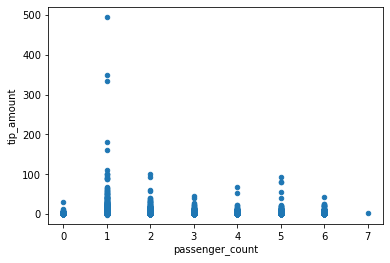

In [16]:
df.to_pandas().plot(kind='scatter',
                    x='passenger_count', 
                    y='tip_amount')

## That is the DataFrame Tour!
You've seen the basics of the DataFrame and how you interact at with it. Now is a good time to experiment with your own data and see how to parse, clean, and extract meaningful insights from it.

We'll also get into how to run visualization either with popular Python visualization packages, as well as GPU-accelerated visualization packages.


[Continue to the Data Visualization introductory Notebook](data_visualization.ipynb)